In [1]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU(inplace=False) if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(inplace=False),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [2]:
class VGG16_CBAM(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16_CBAM, self).__init__()
        original_vgg = models.vgg16(pretrained=True)

        # Break the features into stages
        
        self.stage1 = nn.Sequential(*original_vgg.features[:5])
        self.stage2 = nn.Sequential(*original_vgg.features[5:10])
        self.stage3 = nn.Sequential(*original_vgg.features[10:17])
        self.stage4 = nn.Sequential(*original_vgg.features[17:24])
        self.stage5 = nn.Sequential(*original_vgg.features[24:31])

        # Add CBAM after each stage
        self.cbam1 = CBAM(64)
        self.cbam2 = CBAM(128)
        self.cbam3 = CBAM(256)
        self.cbam4 = CBAM(512)
        self.cbam5 = CBAM(512)

        # Classifier (VGG-style, but last layer changed for your task)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=False),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=False),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x, explain=False):
        x = self.stage1(x)
        if not explain: x = self.cbam1(x)

        x = self.stage2(x)
        if not explain: x = self.cbam2(x)

        x = self.stage3(x)
        if not explain: x = self.cbam3(x)

        x = self.stage4(x)
        if not explain: x = self.cbam4(x)

        x = self.stage5(x)
        if not explain: x = self.cbam5(x)

        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x




In [3]:
import torchvision.models as models
from torch import nn

vgg = models.vgg16(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 174MB/s]  


In [ ]:
# class VGG16_CBAM(nn.Module):
#     def __init__(self, num_classes=4):  # Change num_classes to your dataset
#         super(VGG16_CBAM, self).__init__()
#         original_vgg = models.vgg16(pretrained=True)

#         # Break the features into stages
#         self.stage1 = nn.Sequential(*original_vgg.features[:5])    # Conv64 x2 + MaxPool
#         self.stage2 = nn.Sequential(*original_vgg.features[5:10])  # Conv128 x2 + MaxPool
#         self.stage3 = nn.Sequential(*original_vgg.features[10:17]) # Conv256 x3 + MaxPool
#         self.stage4 = nn.Sequential(*original_vgg.features[17:24]) # Conv512 x3 + MaxPool
#         self.stage5 = nn.Sequential(*original_vgg.features[24:31]) # Conv512 x3 + MaxPool

#         # Add CBAM after each stage
#         self.cbam1 = CBAM(64)
#         self.cbam2 = CBAM(128)
#         self.cbam3 = CBAM(256)
#         self.cbam4 = CBAM(512)
#         self.cbam5 = CBAM(512)

#         # Classifier (same as VGG, but change final layer to num_classes)
#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 7 * 7, 4096),
#             nn.ReLU(True),
#             nn.Dropout(),

#             nn.Linear(4096, 4096),
#             nn.ReLU(True),
#             nn.Dropout(),

#             nn.Linear(4096, num_classes)  # Replace 1000 with your number of classes
#         )

#     def forward(self, x):
#         x = self.stage1(x)
#         x = self.cbam1(x)

#         x = self.stage2(x)
#         x = self.cbam2(x)

#         x = self.stage3(x)
#         x = self.cbam3(x)

#         x = self.stage4(x)
#         x = self.cbam4(x)

#         x = self.stage5(x)
#         x = self.cbam5(x)

#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x


In [4]:
model = VGG16_CBAM(num_classes=10)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)




In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
# num_epochs = 10

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_Diease/Rice_Leaf_Diease/train', transform=transform)
test_dataset = datasets.ImageFolder('/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_Diease/Rice_Leaf_Diease/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes


In [ ]:
# for epoch in range(num_epochs):
#     model.train()
#     total_loss, correct, total = 0, 0, 0

#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)

#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         _, preds = outputs.max(1)
#         correct += preds.eq(labels).sum().item()
#         total += labels.size(0)

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")


In [7]:
model = VGG16_CBAM(num_classes=10)
model.load_state_dict(torch.load("/kaggle/input/cbam-vgg16-rice-code/vgg16_cbam_grape_leaf_Rice.pth"))
model.to(device)


<ipython-input-7-65ca6b4ed353>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/cbam-vgg16-rice-code/vgg16_cbam_grape_leaf_Ri

VGG16_CBAM(
  (stage1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Ma

In [8]:
def extract_cbam_features(model, image_tensor):
    model.eval()
    x = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        x = model.stage1(x)
        cbam1 = model.cbam1(x)

        x = model.stage2(cbam1)
        cbam2 = model.cbam2(x)

        x = model.stage3(cbam2)
        cbam3 = model.cbam3(x)

        x = model.stage4(cbam3)
        cbam4 = model.cbam4(x)

        x = model.stage5(cbam4)
        cbam5 = model.cbam5(x)

    return [cbam1, cbam2, cbam3, cbam4, cbam5]


In [9]:
import matplotlib.pyplot as plt

def show_attention_map(feature_map, title="CBAM Output"):
    fmap = feature_map.squeeze(0).mean(dim=0).cpu().numpy()  # Mean over channels
    plt.imshow(fmap, cmap='jet')
    plt.title(title)
    plt.axis('off')
    plt.colorbar()
    plt.show()


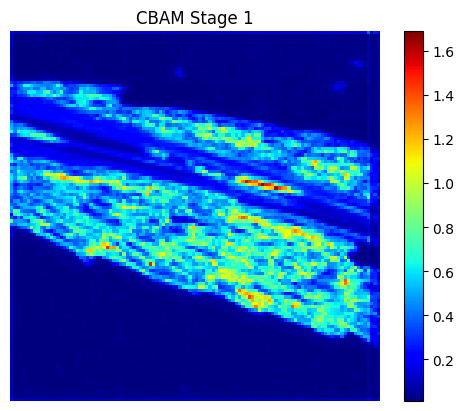

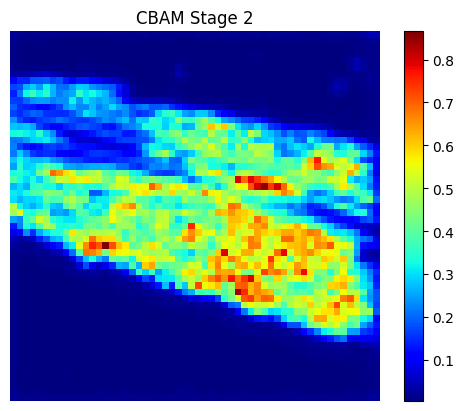

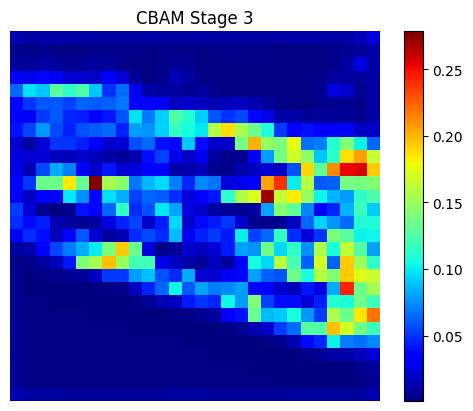

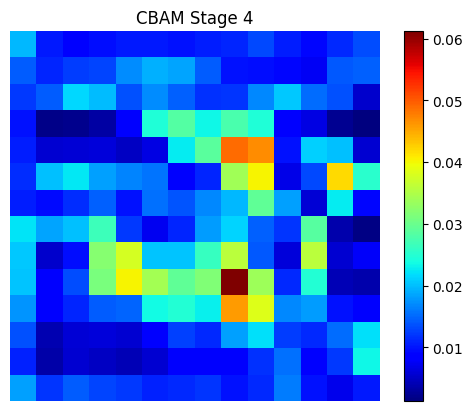

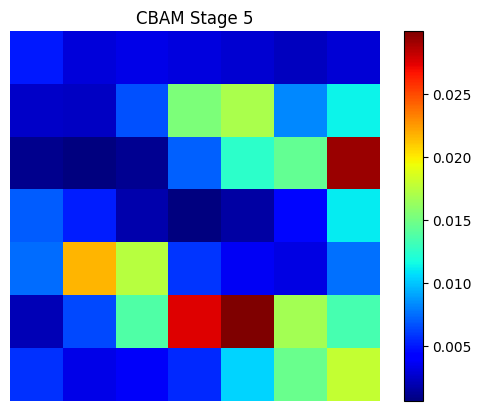

In [10]:
image, label = test_dataset[0]
cbam_outputs = extract_cbam_features(model, image)

# Show CBAM from different stages
for i, out in enumerate(cbam_outputs, 1):
    show_attention_map(out, f"CBAM Stage {i}")


In [ ]:
# # Save the model to a file
# model_path = "/kaggle/working/vgg16_cbam_grape_leaf.pth"
# torch.save(model.state_dict(), model_path)

# print(f"Model saved at {model_path}")


In [ ]:
# torch.save(model, "/kaggle/working/vgg16_cbam_grape_leaf_full.pth")


In [11]:
class_names = train_dataset.classes  # ['Black_rot', 'Esca', 'Leaf_blight', 'Healthy']
print("Class names:", class_names)


Class names: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro']


In [15]:
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F

def predict_image(model, image_path, class_names):
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Inference
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probs = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
    
    predicted_label = class_names[predicted_class]
    confidence = probs[0][predicted_class].item()

    return predicted_label, confidence


In [16]:
# Example: Predict using a test image
img_path = '/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_Diease/Rice_Leaf_Diease/test/brown_spot/20231006_165551.jpg'  # change path as needed
label, conf = predict_image(model, img_path, class_names)

print(f"Predicted: {label} ({conf * 100:.2f}% confidence)")


Predicted: brown_spot (99.99% confidence)


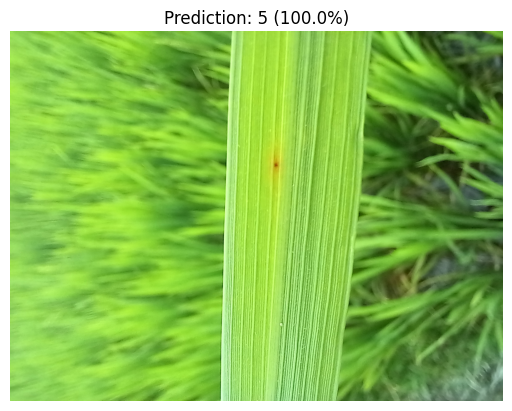

In [30]:
import matplotlib.pyplot as plt

def show_image_with_prediction(image_path, label, confidence):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Prediction: {label} ({confidence * 100:.1f}%)")
    plt.axis("off")
    plt.show()

show_image_with_prediction(img_path, label, conf)


In [ ]:
# def predict_batch(model, dataset, class_names, num_images=10):
#     model.eval()
#     predictions = []

#     for i in range(num_images):
#         image, label = dataset[i]
#         image_tensor = image.unsqueeze(0).to(device)

#         with torch.no_grad():
#             output = model(image_tensor)
#             probs = F.softmax(output, dim=1)
#             pred_class_idx = torch.argmax(probs, dim=1).item()
#             confidence = probs[0][pred_class_idx].item()

#         pred_label = class_names[pred_class_idx]
#         true_label = class_names[label]
        
#         predictions.append({
#             "Index": i,
#             "Predicted": pred_label,
#             "True": true_label,
#             "Confidence": confidence
#         })

#     return predictions


In [ ]:
# batch_preds = predict_batch(model, test_dataset, class_names, num_images=10)

# for pred in batch_preds:
#     print(f"[{pred['Index']}] Predicted: {pred['Predicted']} ({pred['Confidence']*100:.1f}%) | True: {pred['True']}")


In [ ]:
# def show_preds(dataset, predictions):
#     plt.figure(figsize=(15, 6))
#     for i, pred in enumerate(predictions):
#         img, _ = dataset[pred["Index"]]
#         img = img.permute(1, 2, 0).numpy()  # CHW → HWC
#         mean = [0.485, 0.456, 0.406]
#         std = [0.229, 0.224, 0.225]
#         img = std * img + mean  # Unnormalize
#         img = img.clip(0, 1)

#         plt.subplot(2, 5, i + 1)
#         plt.imshow(img)
#         plt.title(f'Pred: {pred["Predicted"]}\nTrue: {pred["True"]}')
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()

# show_preds(test_dataset, batch_preds)


In [17]:
def extract_cbam_features(model, image_tensor):
    model.eval()
    x = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        x = model.stage1(x)
        cbam1 = model.cbam1(x)

        x = model.stage2(cbam1)
        cbam2 = model.cbam2(x)

        x = model.stage3(cbam2)
        cbam3 = model.cbam3(x)

        x = model.stage4(cbam3)
        cbam4 = model.cbam4(x)

        x = model.stage5(cbam4)
        cbam5 = model.cbam5(x)

    return [cbam1, cbam2, cbam3, cbam4, cbam5]


In [ ]:
# def show_cbam_attention_maps(cbam_outputs, title_prefix="Stage"):
#     plt.figure(figsize=(15, 3))
#     for i, feature_map in enumerate(cbam_outputs):
#         fmap = feature_map.squeeze(0).mean(dim=0).cpu().numpy()  # Average across channels
#         plt.subplot(1, 5, i + 1)
#         plt.imshow(fmap, cmap='jet')
#         plt.title(f"{title_prefix} {i+1}")
#         plt.axis("off")
#     plt.tight_layout()
#     plt.show()


In [ ]:
# for i in range(5):  # Adjust number of images to visualize
#     img, label = test_dataset[i]
#     image_tensor = img.to(device)

#     print(f"Image {i+1}: True = {class_names[label]}")
    
#     cbam_outputs = extract_cbam_features(model, image_tensor)
#     show_cbam_attention_maps(cbam_outputs, title_prefix=f"CBAM {i+1}")


In [18]:
def denormalize_image(tensor):
    """Convert normalized tensor image back to original image"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (tensor.cpu() * std + mean).clamp(0, 1)


In [19]:
import cv2
import numpy as np

def overlay_cbam_on_image(image_tensor, attention_map, alpha=0.5):
    """Overlay a single CBAM attention map on an image"""
    image = denormalize_image(image_tensor).permute(1, 2, 0).numpy()  # CHW → HWC

    # Resize attention map to match image size
    att_map = attention_map.cpu().squeeze(0).mean(0).numpy()  # mean over channels
    att_map = cv2.resize(att_map, (image.shape[1], image.shape[0]))

    # Normalize attention map to 0-255 & convert to heatmap
    att_map = (att_map - att_map.min()) / (att_map.max() - att_map.min())
    att_map = np.uint8(255 * att_map)
    heatmap = cv2.applyColorMap(att_map, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    # Blend heatmap with original image
    overlay = (1 - alpha) * image + alpha * heatmap
    return image, overlay


In [ ]:
def visualize_cbam_overlay(model, dataset, index=0, stage=4):
    img, label = dataset[index]
    image_tensor = img.to(device)
    true_label = class_names[label]

    # Extract CBAM features
    cbam_outputs = extract_cbam_features(model, image_tensor)

    # Choose stage (1 to 5) — default is stage 4 (deeper features)
    cbam_output = cbam_outputs[stage - 1]

    # Overlay attention
    original, overlay = overlay_cbam_on_image(image_tensor, cbam_output)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"CBAM Attention Overlay (Stage {stage})\nTrue Label: {true_label}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
# Try with any index and CBAM stage (1 to 5)
visualize_cbam_overlay(model, test_dataset, index=0, stage=4)


In [ ]:
# Try with any index and CBAM stage (1 to 5)
visualize_cbam_overlay(model, test_dataset, index=1, stage=4)

In [ ]:
# Try with any index and CBAM stage (1 to 5)
visualize_cbam_overlay(model, test_dataset, index=20, stage=4)

In [ ]:
# Try with any index and CBAM stage (1 to 5)
visualize_cbam_overlay(model, test_dataset, index=32, stage=4)

In [ ]:
# Try with any index and CBAM stage (1 to 5)
visualize_cbam_overlay(model, test_dataset, index=40, stage=4)

In [ ]:
# Try with any index and CBAM stage (1 to 5)
visualize_cbam_overlay(model, test_dataset, index=400, stage=4)

In [ ]:
# Try with any index and CBAM stage (1 to 5)
visualize_cbam_overlay(model, test_dataset, index=500, stage=4)

In [ ]:
# Try with any index and CBAM stage (1 to 5)
visualize_cbam_overlay(model, test_dataset, index=550, stage=4)

In [ ]:
# Try with any index and CBAM stage (1 to 5)
visualize_cbam_overlay(model, test_dataset, index=600, stage=4)

In [ ]:
# Try with any index and CBAM stage (1 to 5)
visualize_cbam_overlay(model, test_dataset, index=900, stage=4)

In [ ]:
# Try with any index and CBAM stage (1 to 5)
visualize_cbam_overlay(model, test_dataset, index=1000, stage=4)

In [ ]:
# Try with any index and CBAM stage (1 to 5)
visualize_cbam_overlay(model, test_dataset, index=1200, stage=4)

In [ ]:
# Try with any index and CBAM stage (1 to 5)
visualize_cbam_overlay(model, test_dataset, index=1600, stage=4)

In [ ]:
# Try with any index and CBAM stage (1 to 5)
visualize_cbam_overlay(model, test_dataset, index=1650, stage=4)

In [ ]:
# Try with any index and CBAM stage (1 to 5)
visualize_cbam_overlay(model, test_dataset, index=1750, stage=4)

In [ ]:
# def visualize_all_cbam_stages(model, dataset, index=0):
#     img, label = dataset[index]
#     image_tensor = img.to(device)
#     true_label = class_names[label]

#     cbam_outputs = extract_cbam_features(model, image_tensor)

#     fig, axs = plt.subplots(1, 6, figsize=(18, 4))
    
#     # Original Image
#     original_image = denormalize_image(image_tensor).permute(1, 2, 0).numpy()
#     axs[0].imshow(original_image)
#     axs[0].set_title("Original")
#     axs[0].axis("off")

#     # CBAM Overlays
#     for i in range(5):
#         _, overlay = overlay_cbam_on_image(image_tensor, cbam_outputs[i])
#         axs[i+1].imshow(overlay)
#         axs[i+1].set_title(f"CBAM Stage {i+1}")
#         axs[i+1].axis("off")

#     plt.suptitle(f"True Label: {true_label}", fontsize=14)
#     plt.tight_layout()
#     plt.show()


In [ ]:
visualize_all_cbam_stages(model, test_dataset, index=0)  # You can change the index!


In [ ]:
visualize_all_cbam_stages(model, test_dataset, index=2)  # You can change the index!


In [ ]:
visualize_all_cbam_stages(model, test_dataset, index=500)  # You can change the index!


In [ ]:
visualize_all_cbam_stages(model, test_dataset, index=600)  # You can change the index!


In [ ]:
visualize_all_cbam_stages(model, test_dataset, index=650)  # You can change the index!


In [ ]:
visualize_all_cbam_stages(model, test_dataset, index=700)  # You can change the index!


In [ ]:
visualize_all_cbam_stages(model, test_dataset, index=800)  # You can change the index!


In [ ]:
visualize_all_cbam_stages(model, test_dataset, index=900)  # You can change the index!


In [ ]:
visualize_all_cbam_stages(model, test_dataset, index=950)  # You can change the index!


In [ ]:
visualize_all_cbam_stages(model, test_dataset, index=1000)  # You can change the index!


In [ ]:
visualize_all_cbam_stages(model, test_dataset, index=1100)  # You can change the index!


In [ ]:
visualize_all_cbam_stages(model, test_dataset, index=1250)  # You can change the index!


In [ ]:
visualize_all_cbam_stages(model, test_dataset, index=1600)  # You can change the index!


In [ ]:
visualize_all_cbam_stages(model, test_dataset, index=1650)  # You can change the index!


In [ ]:
visualize_all_cbam_stages(model, test_dataset, index=1700)  # You can change the index!


In [ ]:
# def visualize_all_cbam_stages(model, dataset, index=0, save_dir="./", filename_prefix="cbam_overlay"):
#     import os
#     os.makedirs(save_dir, exist_ok=True)

#     img, label = dataset[index]
#     image_tensor = img.to(device)
#     true_label = class_names[label]

#     cbam_outputs = extract_cbam_features(model, image_tensor)

#     fig, axs = plt.subplots(1, 6, figsize=(18, 4))
    
#     # Original Image
#     original_image = denormalize_image(image_tensor).permute(1, 2, 0).numpy()
#     axs[0].imshow(original_image)
#     axs[0].set_title("Original")
#     axs[0].axis("off")

#     # CBAM Overlays
#     for i in range(5):
#         _, overlay = overlay_cbam_on_image(image_tensor, cbam_outputs[i])
#         axs[i+1].imshow(overlay)
#         axs[i+1].set_title(f"CBAM Stage {i+1}")
#         axs[i+1].axis("off")

#     plt.suptitle(f"True Label: {true_label}", fontsize=14)
#     plt.tight_layout()

#     # Save the figure
#     save_path = os.path.join(save_dir, f"{filename_prefix}_index{index}.png")
#     plt.savefig(save_path)
#     print(f"✅ Saved CBAM overlay to: {save_path}")

#     plt.show()


In [ ]:
# visualize_all_cbam_stages(model, test_dataset, index=2, save_dir="./cbam_outputs", filename_prefix="grape_leaf_cbam")


In [ ]:
def visualize_cbam_with_prediction(model, dataset, index=0, save_dir="./", filename_prefix="cbam_pred"):
    import os
    os.makedirs(save_dir, exist_ok=True)

    model.eval()
    img, label = dataset[index]
    image_tensor = img.to(device).unsqueeze(0)
    true_label = class_names[label]

    # Predict
    with torch.no_grad():
        output = model(image_tensor)
        pred_label = class_names[output.argmax(dim=1).item()]

    # Extract CBAM outputs
    cbam_outputs = extract_cbam_features(model, image_tensor.squeeze(0))

    # Plot original + overlays
    fig, axs = plt.subplots(1, 6, figsize=(20, 4))

    # Original Image
    original_image = denormalize_image(image_tensor.squeeze(0)).permute(1, 2, 0).numpy()
    axs[0].imshow(original_image)
    axs[0].set_title("Original")
    axs[0].axis("off")

    # CBAM overlays
    for i in range(5):
        _, overlay = overlay_cbam_on_image(image_tensor.squeeze(0), cbam_outputs[i])
        axs[i+1].imshow(overlay)
        axs[i+1].set_title(f"CBAM Stage {i+1}")
        axs[i+1].axis("off")

    # Title with prediction
    plt.suptitle(f"True: {true_label} | Predicted: {pred_label}", fontsize=14, color="green" if pred_label == true_label else "red")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save
    save_path = os.path.join(save_dir, f"{filename_prefix}_index{index}.png")
    plt.savefig(save_path)
    print(f"✅ Saved to: {save_path}")

    plt.show()


In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=0, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")


In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=5, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=50, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=100, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=500, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=505, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=501, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=502, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=504, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=550, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=600, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=650, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=700, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=750, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=800, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=801, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=900, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1000, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1005, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1050, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1020, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1025, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1010, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1090, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1100, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1150, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1200, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1201, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1215, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1300, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1350, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1400, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1401, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1410, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1411, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1414, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
visualize_cbam_with_prediction(model, test_dataset, index=1412, save_dir="./cbam_outputs", filename_prefix="cbam_with_pred")

In [ ]:
# visualize_cbam_with_prediction(
#     model,
#     test_dataset,
#     index=0,  # Change index for different test images
#     save_dir="./cbam_outputs",
#     filename_prefix="cbam_with_pred"
# )


In [20]:
import numpy as np

In [21]:
def generate_gradcam(model, input_tensor, target_layer):
    from torchvision import transforms
    import cv2

    input_tensor = input_tensor.unsqueeze(0).to(device)
    model.eval()
    
    grad = {}
    activation = {}

    def save_grad(module, grad_in, grad_out):
        grad["value"] = grad_out[0]

    def save_activation(module, input, output):
        activation["value"] = output

    hook_a = target_layer.register_forward_hook(save_activation)
    hook_g = target_layer.register_backward_hook(save_grad)

    output = model(input_tensor)
    pred_class = output.argmax(dim=1)
    score = output[0, pred_class]
    score.backward()

    # Grad-CAM
    gradients = grad["value"]
    activations = activation["value"]

    pooled_grad = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_grad[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = heatmap.detach().cpu().numpy()
    heatmap = cv2.resize(heatmap, (input_tensor.shape[3], input_tensor.shape[2]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay on image
    original = denormalize_image(input_tensor.squeeze(0)).permute(1, 2, 0).cpu().numpy()
    overlay = cv2.addWeighted((original * 255).astype(np.uint8), 0.6, heatmap_color, 0.4, 0)
    
    hook_a.remove()
    hook_g.remove()

    return overlay


In [ ]:
def compare_cbam_gradcam(model, dataset, index=0, target_layer=None, save_dir="./cbam_vs_gradcam", prefix="compare"):
    import os
    os.makedirs(save_dir, exist_ok=True)

    img, label = dataset[index]
    input_tensor = img.to(device)
    true_label = class_names[label]

    # Prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor.unsqueeze(0))
        pred_label = class_names[output.argmax(dim=1).item()]

    # Grad-CAM heatmap
    gradcam_overlay = generate_gradcam(model, input_tensor, target_layer)

    # CBAM outputs
    cbam_outputs = extract_cbam_features(model, input_tensor)

    # Plot all
    fig, axs = plt.subplots(1, 7, figsize=(22, 4))

    # Original
    original_image = denormalize_image(input_tensor).permute(1, 2, 0).cpu().numpy()
    axs[0].imshow(original_image)
    axs[0].set_title("Original")
    axs[0].axis("off")

    # Grad-CAM
    axs[1].imshow(gradcam_overlay)
    axs[1].set_title("Grad-CAM")
    axs[1].axis("off")

    # CBAM Stages
    for i in range(5):
        _, overlay = overlay_cbam_on_image(input_tensor, cbam_outputs[i])
        axs[i+2].imshow(overlay)
        axs[i+2].set_title(f"CBAM {i+1}")
        axs[i+2].axis("off")

    # Title with prediction
    plt.suptitle(f"True: {true_label} | Pred: {pred_label}", fontsize=14,
                 color="green" if pred_label == true_label else "red")

    # Save and show
    filename = f"{prefix}_index{index}.png"
    save_path = os.path.join(save_dir, filename)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path)
    plt.show()

    print(f"✅ Saved: {save_path}")


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=138,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# # Choose the last conv layer of VGG16 (before classifier)
# target_layer = model.stage5[-1]  # Usually works for VGG16-style

# compare_cbam_gradcam(
#     model,
#     test_dataset,
#     index=1,
#     target_layer=target_layer,
#     save_dir="./cbam_vs_gradcam",
#     prefix="grape_comparison"
# )


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=501,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=505,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=1000,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)

In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=1005,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)

In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=1410,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)

In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=1414,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)

In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=140,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)

In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=400,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=450,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=500,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=550,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=600,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=700,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=900,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=100,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=1000,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=1050,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=1080,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=1200,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=1250,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=1300,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=1500,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=1550,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=1551,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=1600,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [ ]:
# Choose the last conv layer of VGG16 (before classifier)
target_layer = model.stage5[-1]  # Usually works for VGG16-style

compare_cbam_gradcam(
    model,
    test_dataset,
    index=1650,
    target_layer=target_layer,
    save_dir="./cbam_vs_gradcam",
    prefix="grape_comparison"
)


In [22]:
import os


In [ ]:
# from tqdm import tqdm  # for progress bar

# def compare_cbam_gradcam_all(
#     model,
#     dataset,
#     target_layer,
#     indices=None,
#     save_dir="./cbam_vs_gradcam",
#     prefix="grape_comparison"
# ):
#     os.makedirs(save_dir, exist_ok=True)
#     model.eval()

#     if indices is None:
#         indices = range(len(dataset))  # default: all test images

#     for idx in tqdm(indices, desc="Generating Grad-CAM + CBAM visualizations"):
#         try:
#             compare_cbam_gradcam(
#                 model=model,
#                 dataset=dataset,
#                 index=idx,
#                 target_layer=target_layer,
#                 save_dir=save_dir,
#                 prefix=prefix
#             )
#         except Exception as e:
#             print(f"❌ Skipping index {idx}: {e}")


In [ ]:
# target_layer = model.stage5[-1]  # usually the last conv layer
# compare_cbam_gradcam_all(model, test_dataset, target_layer, indices=range(10))


In [ ]:
# def get_misclassified_indices(model, dataset):
#     model.eval()
#     misclassified = []
    
#     for idx in range(len(dataset)):
#         img, true_label = dataset[idx]
#         img = img.to(device).unsqueeze(0)
#         with torch.no_grad():
#             output = model(img)
#             pred_label = output.argmax(dim=1).item()
        
#         if pred_label != true_label:
#             misclassified.append(idx)
    
#     return misclassified


In [ ]:
# # Get last conv layer for Grad-CAM
# target_layer = model.stage5[-1]

# # Step 1: Get misclassified indices
# misclassified_indices = get_misclassified_indices(model, test_dataset)
# print(f"❗ Total misclassified: {len(misclassified_indices)}")

# # Step 2: Run Grad-CAM + CBAM visualization loop
# compare_cbam_gradcam_all(
#     model,
#     test_dataset,
#     target_layer=target_layer,
#     indices=misclassified_indices,
#     save_dir="./cbam_vs_gradcam_misclassified",
#     prefix="misclassified"
# )


In [ ]:
# def evaluate_predictions(model, dataset):
#     model.eval()
#     correct = 0
#     total = len(dataset)

#     for idx in range(total):
#         img, true_label = dataset[idx]
#         img = img.to(device).unsqueeze(0)
#         with torch.no_grad():
#             output = model(img)
#             pred_label = output.argmax(dim=1).item()
        
#         if pred_label == true_label:
#             correct += 1
#         else:
#             print(f"❌ Index {idx} — True: {class_names[true_label]} | Pred: {class_names[pred_label]}")

#     accuracy = correct / total * 100
#     print(f"\n✅ Accuracy: {correct}/{total} = {accuracy:.2f}%")


In [ ]:
# evaluate_predictions(model, test_dataset)


In [23]:
!pip install grad-cam --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Ensure model is on correct device
model.to(device)
model.eval()


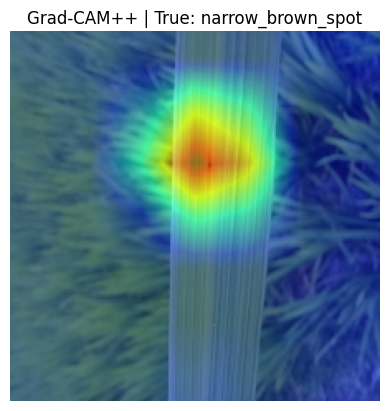

In [25]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


# Choose layer (e.g., last conv layer of stage5)
target_layer = model.stage5[-1]

# Grad-CAM++ object (no use_cuda)
cam_pp = GradCAMPlusPlus(model=model, target_layers=[target_layer])

# Pick an image
index = 1522
img_tensor, label = test_dataset[index]
input_tensor = img_tensor.unsqueeze(0).to(device)

# Grad-CAM++ for target class
targets = [ClassifierOutputTarget(label)]
grayscale_cam_pp = cam_pp(input_tensor=input_tensor, targets=targets)[0]

# Convert tensor to normalized image
rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

# Overlay CAM
overlay = show_cam_on_image(rgb_img, grayscale_cam_pp, use_rgb=True)

# Plot
plt.imshow(overlay)
plt.title(f"Grad-CAM++ | True: {class_names[label]}")
plt.axis("off")
plt.show()


In [26]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Define your transform if any
transform = transforms.Compose([transforms.ToTensor()])

# Load the dataset
dataset = ImageFolder(root='/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_Diease/Rice_Leaf_Diease/test', transform=transform)

# Get full paths of all images
image_paths = [sample[0] for sample in dataset.samples]

# Find the index of the specific image
target_image_path = '/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_Diease/Rice_Leaf_Diease/test/brown_spot/20231006_165551.jpg'
index = image_paths.index(target_image_path)

print(f"Index of the image is: {index}")


Index of the image is: 1522


In [27]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus

In [28]:
def compare_all_visuals(model, dataset, index, class_names, save_dir="final_comparison_outputs"):
    model.eval()
    os.makedirs(save_dir, exist_ok=True)

    # Get image + label
    img_tensor, label = dataset[index]
    input_tensor = img_tensor.unsqueeze(0).to(device)
    image_tensor = img_tensor.to(device)
    true_label = class_names[label]

    # Get prediction
    with torch.no_grad():
        output = model(input_tensor)
        pred_idx = output.argmax(dim=1).item()
        pred_label = class_names[pred_idx]

    # RGB image for overlay
    rgb_img = denormalize_image(img_tensor).permute(1, 2, 0).numpy()

    # Grad-CAM
    gradcam = GradCAM(model=model, target_layers=[model.stage5[-1]])
    grayscale_gc = gradcam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(label)])[0]
    overlay_gc = show_cam_on_image(rgb_img, grayscale_gc, use_rgb=True)

    # Grad-CAM++
    gradcam_pp = GradCAMPlusPlus(model=model, target_layers=[model.stage5[-1]])
    grayscale_gc_pp = gradcam_pp(input_tensor=input_tensor, targets=[ClassifierOutputTarget(label)])[0]
    overlay_gc_pp = show_cam_on_image(rgb_img, grayscale_gc_pp, use_rgb=True)

    # CBAM Attention Maps (all 5)
    cbam_outputs = extract_cbam_features(model, image_tensor)
    cbam_overlays = []
    for i in range(5):
        _, cbam_overlay = overlay_cbam_on_image(image_tensor, cbam_outputs[i])
        cbam_overlays.append(cbam_overlay)

    # Plot all: Original | Grad-CAM | Grad-CAM++ | CBAM 1–5
    fig, axes = plt.subplots(1, 8, figsize=(40, 5))
    axes[0].imshow(rgb_img)
    axes[0].set_title("Original", fontsize=14)

    axes[1].imshow(overlay_gc)
    axes[1].set_title("Grad-CAM", fontsize=14)

    axes[2].imshow(overlay_gc_pp)
    axes[2].set_title("Grad-CAM++", fontsize=14)

    for i in range(5):
        axes[3 + i].imshow(cbam_overlays[i])
        axes[3 + i].set_title(f"CBAM Stage {i+1}", fontsize=14)

    for ax in axes:
        ax.axis("off")

    plt.suptitle(f"True: {true_label} | Predicted: {pred_label}", fontsize=18, color='green' if pred_label == true_label else 'red')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/visual_compare_idx{index}.png")
    plt.show()


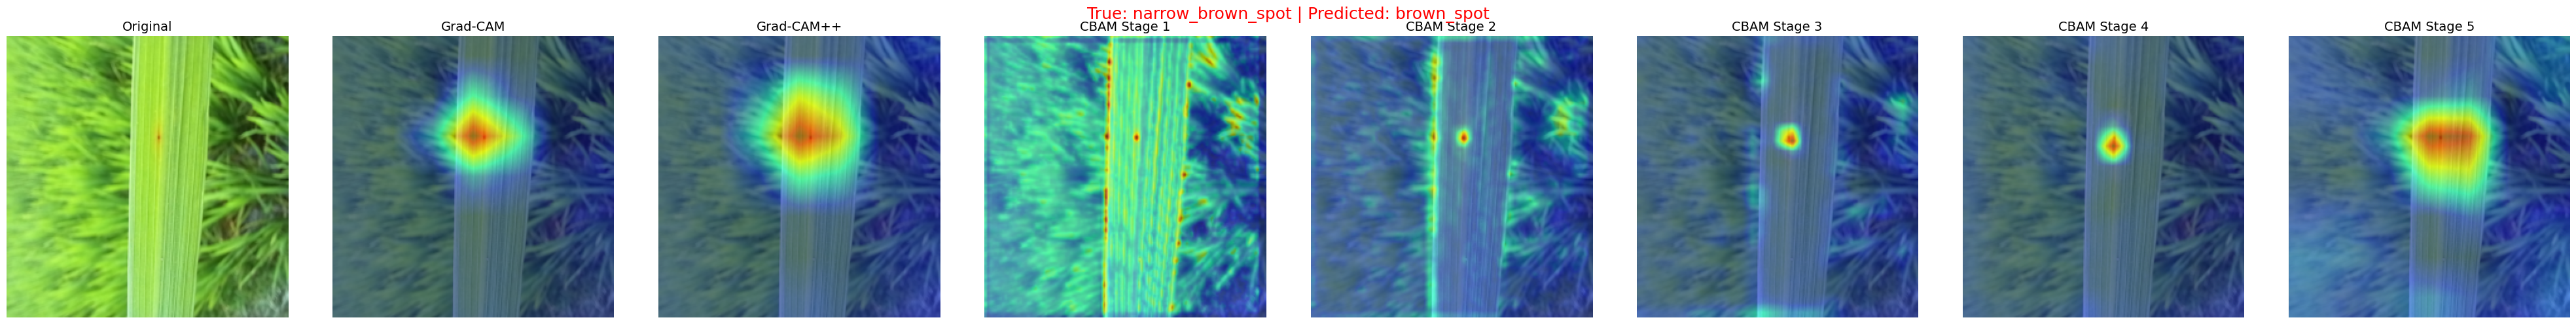

In [29]:
compare_all_visuals(
    model=model,
    dataset=test_dataset,
    index=1522,  # Specify the exact image index
    class_names=class_names,
    save_dir="./final_comparison_outputs"
)


In [ ]:
# from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

# def compare_visual_explanations(model, dataset, index, class_names, save_dir="compare_outputs"):
#     model.eval()

#     # Get image and label
#     img_tensor, label = dataset[index]
#     input_tensor = img_tensor.unsqueeze(0).to(device)
#     true_class = class_names[label]

#     # Preprocess for display
#     rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
#     rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

#     # Grad-CAM (regular)
#     gradcam = GradCAM(model=model, target_layers=[model.stage5[-1]])
#     grayscale_gc = gradcam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(label)])[0]
#     overlay_gc = show_cam_on_image(rgb_img, grayscale_gc, use_rgb=True)

#     # Grad-CAM++
#     gradcam_pp = GradCAMPlusPlus(model=model, target_layers=[model.stage5[-1]])
#     grayscale_gc_pp = gradcam_pp(input_tensor=input_tensor, targets=[ClassifierOutputTarget(label)])[0]
#     overlay_gc_pp = show_cam_on_image(rgb_img, grayscale_gc_pp, use_rgb=True)

#     # CBAM Attention Maps from all stages
#     with torch.no_grad():
#         _ = model(input_tensor)  # run forward to cache CBAM outputs
#         cbam_maps = extract_cbam_features(model, img_tensor)  # ✅ this gives you cbam1 to cbam5


#     # Plot all 7: Original, Grad-CAM, Grad-CAM++, CBAM 1–5
#     fig, axes = plt.subplots(1, 8, figsize=(32, 5))
#     axes[0].imshow(rgb_img)
#     axes[0].set_title("Original")
#     axes[1].imshow(overlay_gc)
#     axes[1].set_title("Grad-CAM")
#     axes[2].imshow(overlay_gc_pp)
#     axes[2].set_title("Grad-CAM++")

#     for i in range(5):
#         fmap = cbam_maps[i].squeeze(0).mean(dim=0).cpu().numpy()
#         fmap -= fmap.min()
#         fmap /= fmap.max() + 1e-8
#         axes[3 + i].imshow(fmap, cmap='jet')
#         axes[3 + i].set_title(f"CBAM {i+1}")


#     for ax in axes:
#         ax.axis('off')

#     plt.suptitle(f"True: {true_class}", fontsize=18)
#     plt.tight_layout()
#     os.makedirs(save_dir, exist_ok=True)
#     plt.savefig(f"{save_dir}/compare_img_{index}.png")
#     plt.show()


In [ ]:
# for idx in range(5):
#     compare_visual_explanations(model, test_dataset, idx, class_names)


In [ ]:
# import os
# import matplotlib.pyplot as plt
# from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

# def compare_all_visuals(model, dataset, index, class_names, save_dir="final_comparison_outputs"):
#     model.eval()
#     os.makedirs(save_dir, exist_ok=True)

#     # Get image + label
#     img_tensor, label = dataset[index]
#     input_tensor = img_tensor.unsqueeze(0).to(device)
#     image_tensor = img_tensor.to(device)
#     true_label = class_names[label]

#     # RGB image for overlay
#     rgb_img = denormalize_image(img_tensor).permute(1, 2, 0).numpy()

#     # Grad-CAM
#     gradcam = GradCAM(model=model, target_layers=[model.stage5[-1]])
#     grayscale_gc = gradcam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(label)])[0]
#     overlay_gc = show_cam_on_image(rgb_img, grayscale_gc, use_rgb=True)

#     # Grad-CAM++
#     gradcam_pp = GradCAMPlusPlus(model=model, target_layers=[model.stage5[-1]])
#     grayscale_gc_pp = gradcam_pp(input_tensor=input_tensor, targets=[ClassifierOutputTarget(label)])[0]
#     overlay_gc_pp = show_cam_on_image(rgb_img, grayscale_gc_pp, use_rgb=True)

#     # CBAM Attention Maps (all 5)
#     cbam_outputs = extract_cbam_features(model, image_tensor)
#     cbam_overlays = []
#     for i in range(5):
#         _, cbam_overlay = overlay_cbam_on_image(image_tensor, cbam_outputs[i])
#         cbam_overlays.append(cbam_overlay)

#     # Plot all: Original | Grad-CAM | Grad-CAM++ | CBAM 1–5
#     fig, axes = plt.subplots(1, 8, figsize=(40, 5))
#     axes[0].imshow(rgb_img)
#     axes[0].set_title("Original", fontsize=14)

#     axes[1].imshow(overlay_gc)
#     axes[1].set_title("Grad-CAM", fontsize=14)

#     axes[2].imshow(overlay_gc_pp)
#     axes[2].set_title("Grad-CAM++", fontsize=14)

#     for i in range(5):
#         axes[3 + i].imshow(cbam_overlays[i])
#         axes[3 + i].set_title(f"CBAM Stage {i+1}", fontsize=14)

#     for ax in axes:
#         ax.axis("off")

#     plt.suptitle(f"True Label: {true_label}", fontsize=18)
#     plt.tight_layout()
#     plt.savefig(f"{save_dir}/visual_compare_idx{index}.png")
#     plt.show()


In [ ]:
# for i in range(3):  # or range(len(test_dataset)) for all
#     compare_all_visuals(model, test_dataset, i, class_names)


In [ ]:
# for i in range(3):  # or range(len(test_dataset)) for all
#     compare_all_visuals(model, test_dataset, i, class_names)

In [ ]:
compare_all_visuals(
    model=model,
    dataset=test_dataset,
    index=1,  # Specify the exact image index
    class_names=class_names,
    save_dir="./final_comparison_outputs"
)


In [ ]:
compare_all_visuals(
    model=model,
    dataset=test_dataset,
    index=501,  # Specify the exact image index
    class_names=class_names,
    save_dir="./final_comparison_outputs"
)


In [ ]:
compare_all_visuals(
    model=model,
    dataset=test_dataset,
    index=505,  # Specify the exact image index
    class_names=class_names,
    save_dir="./final_comparison_outputs"
)


In [ ]:
compare_all_visuals(
    model=model,
    dataset=test_dataset,
    index=1410,  # Specify the exact image index
    class_names=class_names,
    save_dir="./final_comparison_outputs"
)


In [ ]:
compare_all_visuals(
    model=model,
    dataset=test_dataset,
    index=1414,  # Specify the exact image index
    class_names=class_names,
    save_dir="./final_comparison_outputs"
)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

def binarize_heatmap(heatmap, threshold=0.15):
    """Binarize heatmap at a given threshold (15% of max intensity)."""
    heatmap = cv2.normalize(heatmap, None, 0, 1, cv2.NORM_MINMAX)  # Normalize to 0-1
    binary_mask = (heatmap >= threshold).astype(np.uint8)  # Thresholding
    return binary_mask

In [ ]:
def extract_largest_segment(binary_mask):
    """Finds the largest connected component in a binary mask and returns its bounding box."""
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None  # No object detected
    
    largest_contour = max(contours, key=cv2.contourArea)  # Largest segment
    x, y, w, h = cv2.boundingRect(largest_contour)  # Bounding box coordinates
    bbox = [x, y, x + w, y + h]
    
    print(f"Extracted Bounding Box: {bbox}")  # 🔥 Print the bounding box
    return bbox


In [ ]:

def draw_bounding_box(image, bbox, color=(0, 255, 0), thickness=2):
    """Draw bounding box on image."""
    if bbox:
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness)
    return image


In [ ]:

# Load Image and Grad-CAM Heatmap
image_path = "/kaggle/input/grape-disease/grape_dataset/test/Grape___Black_rot/00090b0f-c140-4e77-8d20-d39f67b75fcc___FAM_B.Rot 0376.JPG"
heatmap_path = "/kaggle/input/idx-0-cbam-stg5/idx_0_cbam_stg5.png"

In [ ]:

image = cv2.imread(image_path)
heatmap = cv2.imread(heatmap_path, cv2.IMREAD_GRAYSCALE)

In [ ]:
# Step 1: Binarize Heatmap (Threshold at 15%)
binary_mask = binarize_heatmap(heatmap)

# Step 2: Extract Largest Connected Segment
predicted_bbox = extract_largest_segment(binary_mask)


In [ ]:
# Step 1: Binarize Heatmap (Threshold at 15%)
binary_mask = binarize_heatmap(heatmap)

# Step 2: Extract Largest Connected Segment
predicted_bbox = extract_largest_segment(binary_mask)


In [ ]:
# Step 1: Binarize Heatmap (Threshold at 15%)
binary_mask = binarize_heatmap(heatmap)

# Step 2: Extract Largest Connected Segment
predicted_bbox = extract_largest_segment(binary_mask)


In [ ]:
# Step 3: Draw Bounding Box on Original Image
if predicted_bbox:
    output_image = draw_bounding_box(image.copy(), predicted_bbox)
    
    # Display Results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Bounding Box (Localization)")
    
    plt.show()
else:
    print("No object detected in heatmap.")

In [ ]:
def compute_iou(box1, box2):
    """Compute Intersection over Union (IoU) between two bounding boxes."""
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Compute intersection
    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)

    # Check if there is an intersection
    if x_inter_max <= x_inter_min or y_inter_max <= y_inter_min:
        return 0.0  # No overlap

    intersection_area = (x_inter_max - x_inter_min) * (y_inter_max - y_inter_min)

    # Compute union
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area




In [ ]:

# Insert extracted bounding boxes
bbox_gradcam = [0, 0, 233, 237]
bbox_gradcampp = [53, 19, 205, 206]
bbox_cbam = [66, 24, 169, 183]


In [ ]:
# Insert extracted bounding boxes
bbox_gradcam = [0, 0, 233, 237]
bbox_gradcampp = [53, 19, 205, 206]
bbox_cbam = [54, 19, 175, 192]

In [ ]:
iou_gradcam_vs_gradcampp = compute_iou(bbox_gradcam, bbox_gradcampp)
iou_gradcam_vs_cbam = compute_iou(bbox_gradcam, bbox_cbam)
iou_gradcampp_vs_cbam = compute_iou(bbox_gradcampp, bbox_cbam)

print(f"IoU (Grad-CAM vs Grad-CAM++): {iou_gradcam_vs_gradcampp:.4f}")
print(f"IoU (Grad-CAM vs CBAM): {iou_gradcam_vs_cbam:.4f}")
print(f"IoU (Grad-CAM++ vs CBAM): {iou_gradcampp_vs_cbam:.4f}")


In [ ]:
iou_gradcam_vs_gradcampp = compute_iou(bbox_gradcam, bbox_gradcampp)
iou_gradcam_vs_cbam = compute_iou(bbox_gradcam, bbox_cbam)
iou_gradcampp_vs_cbam = compute_iou(bbox_gradcampp, bbox_cbam)

print(f"IoU (Grad-CAM vs Grad-CAM++): {iou_gradcam_vs_gradcampp:.4f}")
print(f"IoU (Grad-CAM vs CBAM): {iou_gradcam_vs_cbam:.4f}")
print(f"IoU (Grad-CAM++ vs CBAM): {iou_gradcampp_vs_cbam:.4f}")

In [ ]:
import numpy as np

def center_distance(box1, box2):
    """Compute Euclidean distance between bounding box centers."""
    center1 = np.array([(box1[0] + box1[2]) / 2, (box1[1] + box1[3]) / 2])
    center2 = np.array([(box2[0] + box2[2]) / 2, (box2[1] + box2[3]) / 2])
    return np.linalg.norm(center1 - center2)

In [ ]:
# Compute center distance
center_dist_gradcam_vs_gradcampp = center_distance(bbox_gradcam, bbox_gradcampp)
center_dist_gradcam_vs_cbam = center_distance(bbox_gradcam, bbox_cbam)
center_dist_gradcampp_vs_cbam = center_distance(bbox_gradcampp, bbox_cbam)

In [ ]:

print(f"Center Distance (Grad-CAM vs Grad-CAM++): {center_dist_gradcam_vs_gradcampp:.4f}")
print(f"Center Distance (Grad-CAM vs CBAM): {center_dist_gradcam_vs_cbam:.4f}")
print(f"Center Distance (Grad-CAM++ vs CBAM): {center_dist_gradcampp_vs_cbam:.4f}")


In [ ]:

print(f"Center Distance (Grad-CAM vs Grad-CAM++): {center_dist_gradcam_vs_gradcampp:.4f}")
print(f"Center Distance (Grad-CAM vs CBAM): {center_dist_gradcam_vs_cbam:.4f}")
print(f"Center Distance (Grad-CAM++ vs CBAM): {center_dist_gradcampp_vs_cbam:.4f}")


In [ ]:
def bbox_size(box):
    """Compute area of bounding box."""
    return (box[2] - box[0]) * (box[3] - box[1])

# Compute bounding box areas
area_gradcam = bbox_size(bbox_gradcam)
area_gradcampp = bbox_size(bbox_gradcampp)
area_cbam = bbox_size(bbox_cbam)

print(f"Bounding Box Area - Grad-CAM: {area_gradcam}")
print(f"Bounding Box Area - Grad-CAM++: {area_gradcampp}")
print(f"Bounding Box Area - CBAM: {area_cbam}")

In [ ]:
def bbox_size(box):
    """Compute area of bounding box."""
    return (box[2] - box[0]) * (box[3] - box[1])

# Compute bounding box areas
area_gradcam = bbox_size(bbox_gradcam)
area_gradcampp = bbox_size(bbox_gradcampp)
area_cbam = bbox_size(bbox_cbam)

print(f"Bounding Box Area - Grad-CAM: {area_gradcam}")
print(f"Bounding Box Area - Grad-CAM++: {area_gradcampp}")
print(f"Bounding Box Area - CBAM: {area_cbam}")

In [ ]:

# Get class names
class_names = test_dataset.classes


In [ ]:
# Create "gradcam" folder with subfolders for each class
os.makedirs("gradcam", exist_ok=True)
for class_name in class_names:
    os.makedirs(os.path.join("gradcam", class_name), exist_ok=True)


In [ ]:

# Store 10 images per class
classwise_images = defaultdict(list)

In [ ]:
# Collect 10 images per class
for idx, (_, label) in enumerate(test_dataset.samples):
    if len(classwise_images[label]) < 10:
        classwise_images[label].append(idx)

    # Stop once all classes have 10 images
    if all(len(classwise_images[c]) == 10 for c in range(len(class_names))):
        break

In [ ]:
# Generate and save Grad-CAM heatmaps
def process_gradcam(model, dataset, classwise_images):
    target_layer = model.stage5[-1]  # Last conv layer of VGG16

    for class_idx in range(len(class_names)):  # Ensure all classes are processed
        class_name = class_names[class_idx]
        print(f"🔍 Generating and saving Grad-CAM for class: {class_name}")

        for img_count, img_idx in enumerate(classwise_images[class_idx]):
            img_tensor, _ = dataset[img_idx]  # Load image
            gradcam_img = generate_gradcam(model, img_tensor, target_layer)  # Apply Grad-CAM

            # Save the heatmap
            save_path = f"gradcam/{class_name}/{class_name}_{img_count+1}.png"
            cv2.imwrite(save_path, cv2.cvtColor(gradcam_img, cv2.COLOR_RGB2BGR))

# Run Grad-CAM and save heatmaps
process_gradcam(model, test_dataset, classwise_images)

print("✅ Grad-CAM heatmaps saved in the 'gradcam/' folder!")

In [ ]:

# Create "gradcam_plus_plus" folder with subfolders for each class
os.makedirs("gradcam_plus_plus", exist_ok=True)
for class_name in class_names:
    os.makedirs(os.path.join("gradcam_plus_plus", class_name), exist_ok=True)

In [ ]:

# Generate and save Grad-CAM++ heatmaps
def process_gradcam_pp(model, dataset, classwise_images):
    target_layer = model.stage5[-1]  # Last conv layer of VGG16
    cam_pp = GradCAMPlusPlus(model=model, target_layers=[target_layer])

    for class_idx in range(len(class_names)):  # Ensure all classes are processed
        class_name = class_names[class_idx]
        print(f"🔍 Generating and saving Grad-CAM++ for class: {class_name}")

        for img_count, img_idx in enumerate(classwise_images[class_idx]):
            img_tensor, _ = dataset[img_idx]  # Load image
            input_tensor = img_tensor.unsqueeze(0).to(device)

            # Grad-CAM++ heatmap
            targets = [ClassifierOutputTarget(class_idx)]
            grayscale_cam_pp = cam_pp(input_tensor=input_tensor, targets=targets)[0]

            # Convert tensor to normalized image
            rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
            rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

            # Overlay CAM
            overlay = show_cam_on_image(rgb_img, grayscale_cam_pp, use_rgb=True)

            # Save the heatmap
            save_path = f"gradcam_plus_plus/{class_name}/{class_name}_{img_count+1}.png"
            cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

# Run Grad-CAM++ and save heatmaps
process_gradcam_pp(model, test_dataset, classwise_images)

print("✅ Grad-CAM++ heatmaps saved in the 'gradcam_plus_plus/' folder!")

In [ ]:

# # Generate Grad-CAM for 10 images per class
# def process_gradcam(model, dataset, classwise_images):
#     target_layer = model.stage5[-1]  # Last conv layer of VGG16

#     for class_idx in range(len(class_names)):  # Ensure all classes are processed
#         print(f"🔍 Generating Grad-CAM for class: {class_names[class_idx]}")
        
#         for img_idx in classwise_images[class_idx]:
#             img_tensor, _ = dataset[img_idx]  # Load image
#             gradcam_img = generate_gradcam(model, img_tensor, target_layer)  # Apply Grad-CAM

#             # Show the image
#             plt.figure(figsize=(5, 5))
#             plt.imshow(gradcam_img)
#             plt.title(f"Class: {class_names[class_idx]}")
#             plt.axis("off")
#             plt.show()

In [ ]:
# # Run Grad-CAM for all classes
# process_gradcam(model, test_dataset, classwise_images)

In [ ]:
# from collections import defaultdict

# # Store image indexes per class
# classwise_images = defaultdict(list)

# # Loop through dataset and store indices
# for idx, (_, label) in enumerate(test_dataset.samples):
#     if len(classwise_images[label]) < 10:
#         classwise_images[label].append(idx)
    
#     # Stop if we have 10 images for each class
#     if all(len(v) == 10 for v in classwise_images.values()):
#         break


In [ ]:
# # Generate Grad-CAM for 10 images per class
# def process_gradcam(model, dataset, classwise_images):
#     target_layer = model.stage5[-1]  # Last conv layer of VGG16

#     for class_idx, image_indices in classwise_images.items():
#         print(f"🔍 Generating Grad-CAM for class: {class_names[class_idx]}")
        
#         for img_idx in image_indices:
#             img_tensor, _ = dataset[img_idx]  # Load image
#             gradcam_img = generate_gradcam(model, img_tensor, target_layer)  # Apply Grad-CAM

#             # Show the image
#             plt.figure(figsize=(5, 5))
#             plt.imshow(gradcam_img)
#             plt.title(f"Class: {class_names[class_idx]}")
#             plt.axis("off")
#             plt.show()

In [ ]:
# # Run Grad-CAM for all classes
# process_gradcam(model, test_dataset, classwise_images)

In [ ]:
# for index in range(5):  # loop over first 5 test images
#     img_tensor, label = test_dataset[index]
#     input_tensor = img_tensor.unsqueeze(0).to(device)
    
#     # Grad-CAM++ logic here...


In [ ]:
# # Rebuild the model architecture
# model = VGG16_CBAM(num_classes=4)
# model.load_state_dict(torch.load("/kaggle/working/vgg16_cbam_grape_leaf.pth"))
# model = model.to(device)
# model.eval()


In [ ]:
# model = torch.load("/kaggle/working/vgg16_cbam_grape_leaf_full.pth")
# model = model.to(device)
# model.eval()
